In [1]:
import pickle

pkl_paths = [
    "/content/processed_samples_1979.pkl",
    "/content/processed_samples_1980.pkl",
    "/content/processed_samples_1981.pkl",
    "/content/processed_samples_1982.pkl",
    "/content/processed_samples_1983.pkl"
]

all_samples = []

for path in pkl_paths:
    print(f"Loading: {path}")
    with open(path, "rb") as f:
        data = pickle.load(f)

    print(f"  → Loaded {len(data)} samples")
    all_samples.extend(data)

print("\nTOTAL combined samples:", len(all_samples))

MERGED_PATH = "/content/processed_samples_merged.pkl"
with open(MERGED_PATH, "wb") as f:
    pickle.dump(all_samples, f)

print(f"\nMerged file saved to: {MERGED_PATH}")


Loading: /content/processed_samples_1979.pkl
  → Loaded 848 samples
Loading: /content/processed_samples_1980.pkl
  → Loaded 786 samples
Loading: /content/processed_samples_1981.pkl
  → Loaded 740 samples
Loading: /content/processed_samples_1982.pkl
  → Loaded 1024 samples
Loading: /content/processed_samples_1983.pkl
  → Loaded 433 samples

TOTAL combined samples: 3831

Merged file saved to: /content/processed_samples_merged.pkl


In [2]:
import pickle

PICKLE_PATH = "/content/processed_samples_merged.pkl"

with open(PICKLE_PATH, "rb") as f:
    samples = pickle.load(f)

print("Total samples:", len(samples))

Total samples: 3831


In [3]:
uv_shapes = set()
sst_shapes = set()
p_shapes = set()

bad_samples = 0

for s in samples:
    env_list = s.get("environmental_data", [])
    if not env_list:
        bad_samples += 1
        continue

    for env in env_list:
        uv_shapes.add(env["wind"]["u_300"].shape)
        sst_shapes.add(env["sst"].shape)
        p_shapes.add(env["geopotential"].shape)

print("Unique UV shapes:", uv_shapes)
print("Unique SST shapes:", sst_shapes)
print("Unique Geopotential shapes:", p_shapes)
print("Samples with empty environmental_data:", bad_samples)

Unique UV shapes: {(21, 21)}
Unique SST shapes: {(21, 21)}
Unique Geopotential shapes: {(21, 41)}
Samples with empty environmental_data: 0


In [4]:
import pickle
import numpy as np

PICKLE_PATH = "/content/processed_samples_merged.pkl"

with open(PICKLE_PATH, "rb") as f:
    samples = pickle.load(f)

traj_shapes = set()
env_lengths = set()
missing_target_count = 0

FORECAST_HOURS = [6, 12, 24, 48, 72]

for s in samples:
    traj = s["input_trajectory"]
    env  = s["environmental_data"]
    traj_shapes.add(traj.shape)
    env_lengths.add(len(env))

    if any(s["targets"].get(f"t+{h}h") is None for h in FORECAST_HOURS):
        missing_target_count += 1

print("Trajectory shapes:", traj_shapes)
print("Env list lengths:", env_lengths)
print("Samples missing any target:", missing_target_count)

Trajectory shapes: {(8, 6)}
Env list lengths: {8}
Samples missing any target: 124


In [5]:
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler

PICKLE_PATH = "/content/processed_samples_merged.pkl"

FORECAST_HOURS = [6, 12, 24, 48, 72]
N_STEPS = 8

with open(PICKLE_PATH, "rb") as f:
    samples = pickle.load(f)

print("Total samples in file:", len(samples))

P_H, P_W = None, None
for s in samples:
    env_list = s["environmental_data"]
    if len(env_list) > 0:
        gp0 = env_list[0]["geopotential"]
        P_H, P_W = gp0.shape
        break

print("Inferred geopotential shape:", P_H, P_W)

X_traj_list = []
X_uv_list   = []
X_sst_list  = []
X_p_list    = []
y_list      = []
lat0_list   = []
lon0_list   = []

n_skipped = 0

for s in samples:
    traj     = s["input_trajectory"]
    env_list = s["environmental_data"]
    targets  = s["targets"]
    lat0, lon0 = s["current_position"]

    if traj.shape[0] != N_STEPS:
        n_skipped += 1
        continue
    if len(env_list) != N_STEPS:
        n_skipped += 1
        continue
    if any(targets.get(f"t+{h}h") is None for h in FORECAST_HOURS):
        n_skipped += 1
        continue

    X_traj_list.append(traj)

    uv_t_series = []
    for env in env_list:
        w = env["wind"]
        u300 = w["u_300"]
        v300 = w["v_300"]
        u500 = w["u_500"]
        v500 = w["v_500"]
        u700 = w["u_700"]
        v700 = w["v_700"]
        u850 = w["u_850"]
        v850 = w["v_850"]

        uv_t = np.stack(
            [u300, v300, u500, v500, u700, v700, u850, v850],
            axis=-1
        )
        uv_t_series.append(uv_t)

    uv_sample = np.stack(uv_t_series, axis=0)
    X_uv_list.append(uv_sample)


    sst_t_series = [env["sst"] for env in env_list]
    sst_sample = np.stack(sst_t_series, axis=0)[..., None]
    X_sst_list.append(sst_sample)


    p_t_series = [env["geopotential"] for env in env_list]
    p_sample = np.stack(p_t_series, axis=0)[..., None]
    X_p_list.append(p_sample)

    y_offsets = []
    for h in FORECAST_HOURS:
        t = targets[f"t+{h}h"]
        dlat = t["lat"] - lat0
        dlon = t["lon"] - lon0
        y_offsets.extend([dlat, dlon])
    y_list.append(y_offsets)

    lat0_list.append([lat0])
    lon0_list.append([lon0])

print("Skipped samples:", n_skipped)
print("Kept samples:", len(X_traj_list))

X_traj = np.stack(X_traj_list, axis=0)
X_uv   = np.stack(X_uv_list,   axis=0)
X_sst  = np.stack(X_sst_list,  axis=0)
X_p    = np.stack(X_p_list,    axis=0)
y      = np.stack(y_list,      axis=0)
lat0   = np.array(lat0_list)
lon0   = np.array(lon0_list)

print("X_traj:", X_traj.shape)
print("X_uv:",   X_uv.shape)
print("X_sst:",  X_sst.shape)
print("X_p:",    X_p.shape)
print("y:",      y.shape)

def clean_array(arr, name):
    finite_vals = arr[np.isfinite(arr)]
    mean_val = 0.0 if finite_vals.size == 0 else finite_vals.mean()
    print(f"{name}: mean (finite) = {mean_val}")
    arr_clean = np.nan_to_num(arr, nan=mean_val, posinf=mean_val, neginf=mean_val)
    print(f"{name}: has NaN after cleaning ->", np.isnan(arr_clean).any())
    print(f"{name}: has non-finite after cleaning ->", (~np.isfinite(arr_clean)).any())
    print()
    return arr_clean

X_uv  = clean_array(X_uv,  "X_uv")
X_sst = clean_array(X_sst, "X_sst")
X_p   = clean_array(X_p,   "X_p")

traj_scaler = MinMaxScaler(feature_range=(0, 1))
X_traj_flat = X_traj.reshape(X_traj.shape[0], -1)
X_traj_flat_scaled = traj_scaler.fit_transform(X_traj_flat)
X_traj_scaled = X_traj_flat_scaled.reshape(X_traj.shape)

y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = y_scaler.fit_transform(y)

Total samples in file: 3831
Inferred geopotential shape: 21 41
Skipped samples: 124
Kept samples: 3707
X_traj: (3707, 8, 6)
X_uv: (3707, 8, 21, 21, 8)
X_sst: (3707, 8, 21, 21, 1)
X_p: (3707, 8, 21, 41, 1)
y: (3707, 10)
X_uv: mean (finite) = 0.5885350704193115
X_uv: has NaN after cleaning -> False
X_uv: has non-finite after cleaning -> False

X_sst: mean (finite) = 301.46551513671875
X_sst: has NaN after cleaning -> False
X_sst: has non-finite after cleaning -> False

X_p: mean (finite) = 57408.48046875
X_p: has NaN after cleaning -> False
X_p: has non-finite after cleaning -> False



In [6]:
from sklearn.model_selection import train_test_split

N = X_traj_scaled.shape[0]

N_STEPS = X_traj_scaled.shape[1]
F_TRAJ  = X_traj_scaled.shape[2]

H_uv,  W_uv  = X_uv.shape[2],  X_uv.shape[3]
H_sst, W_sst = X_sst.shape[2], X_sst.shape[3]
H_p,   W_p   = X_p.shape[2],   X_p.shape[3]

OUT_DIM = y_scaled.shape[1]

print("N_STEPS, F_TRAJ:", N_STEPS, F_TRAJ)
print("UV grid:",  H_uv,  W_uv)
print("SST grid:", H_sst, W_sst)
print("P  grid:",  H_p,   W_p)
print("OUT_DIM:",  OUT_DIM)

idx = np.arange(N)
train_idx, test_idx = train_test_split(idx, test_size=0.1, random_state=42)
train_idx, val_idx  = train_test_split(train_idx, test_size=0.1111, random_state=42)

def subset(arr, idxs):
    return arr[idxs]

train_X_uv   = subset(X_uv,          train_idx)
train_X_sst  = subset(X_sst,         train_idx)
train_X_p    = subset(X_p,           train_idx)
train_X_traj = subset(X_traj_scaled, train_idx)
train_y      = subset(y_scaled,      train_idx)

val_X_uv   = subset(X_uv,          val_idx)
val_X_sst  = subset(X_sst,         val_idx)
val_X_p    = subset(X_p,           val_idx)
val_X_traj = subset(X_traj_scaled, val_idx)
val_y      = subset(y_scaled,      val_idx)

test_X_uv   = subset(X_uv,          test_idx)
test_X_sst  = subset(X_sst,         test_idx)
test_X_p    = subset(X_p,           test_idx)
test_X_traj = subset(X_traj_scaled, test_idx)
test_y      = subset(y_scaled,      test_idx)

for name, arr in [
    ("train_X_uv", train_X_uv),
    ("train_X_sst", train_X_sst),
    ("train_X_p", train_X_p),
    ("train_X_traj", train_X_traj),
    ("train_y", train_y),
]:
    print(name, "has NaN:", np.isnan(arr).any(), "non-finite:", (~np.isfinite(arr)).any())

N_STEPS, F_TRAJ: 8 6
UV grid: 21 21
SST grid: 21 21
P  grid: 21 41
OUT_DIM: 10
train_X_uv has NaN: False non-finite: False
train_X_sst has NaN: False non-finite: False
train_X_p has NaN: False non-finite: False
train_X_traj has NaN: False non-finite: False
train_y has NaN: False non-finite: False


In [22]:
import tensorflow as tf
from tensorflow.keras import layers, Model

uv_input = layers.Input(shape=(N_STEPS, H_uv, W_uv, 8), name="uv_input")
uv_out = layers.TimeDistributed(
    layers.Conv2D(16, kernel_size=(9, 9), strides=3, activation="relu")
)(uv_input)
uv_out = layers.TimeDistributed(layers.BatchNormalization())(uv_out)
uv_out = layers.TimeDistributed(
    layers.MaxPool2D(pool_size=(3, 3), strides=2, padding="valid")
)(uv_out)
uv_flat  = layers.Flatten()(uv_out)
uv_dense = layers.Dense(128, activation="relu")(uv_flat)
uv_dense = layers.Dense(32,  activation="relu")(uv_dense)

sst_input = layers.Input(shape=(N_STEPS, H_sst, W_sst, 1), name="sst_input")
sst_out = layers.TimeDistributed(
    layers.Conv2D(8, kernel_size=(9, 9), strides=3, activation="relu")
)(sst_input)
sst_out = layers.TimeDistributed(layers.BatchNormalization())(sst_out)
sst_out = layers.TimeDistributed(
    layers.MaxPool2D(pool_size=(3, 3), strides=2, padding="valid")
)(sst_out)
sst_flat  = layers.Flatten()(sst_out)
sst_dense = layers.Dense(128, activation="relu")(sst_flat)
sst_dense = layers.Dense(32,  activation="relu")(sst_dense)

p_input = layers.Input(shape=(N_STEPS, H_p, W_p, 1), name="p_input")
p_out = layers.TimeDistributed(
    layers.Conv2D(16, kernel_size=(9, 15), strides=3, activation="relu")
)(p_input)
p_out = layers.TimeDistributed(layers.BatchNormalization())(p_out)
p_out = layers.TimeDistributed(
    layers.MaxPool2D(pool_size=(3, 5), strides=2, padding="valid")
)(p_out)
p_flat  = layers.Flatten()(p_out)
p_dense = layers.Dense(128, activation="relu")(p_flat)
p_dense = layers.Dense(32,  activation="relu")(p_dense)

traj_input = layers.Input(shape=(N_STEPS, F_TRAJ), name="traj_input")
gru_1 = layers.GRU(128, return_sequences=True,  activation="relu")(traj_input)
gru_2 = layers.GRU(32,  return_sequences=False, activation="relu")(gru_1)

merged = layers.Concatenate(axis=-1)([uv_dense, sst_dense, p_dense, gru_2])

output = layers.Dense(OUT_DIM, activation="linear", name="output")(merged)

model = Model(
    inputs=[uv_input, sst_input, p_input, traj_input],
    outputs=output,
)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=2280,
    decay_rate=0.94,
    staircase=True,
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    loss="mean_squared_error",
    optimizer=optimizer,
    metrics=["mae", "mape"],
)

model.summary()

checkpoint_path = "ctrl_cnn_gru_72.weights.h5"
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
)

history = model.fit(
    [train_X_uv, train_X_sst, train_X_p, train_X_traj],
    train_y,
    validation_data=([val_X_uv, val_X_sst, val_X_p, val_X_traj], val_y),
    epochs=100,
    batch_size=64,
    callbacks=checkpoint_cb,
    verbose=2,
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ uv_input            │ (None, 8, 21, 21, │          0 │ -                 │
│ (InputLayer)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sst_input           │ (None, 8, 21, 21, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_input             │ (None, 8, 21, 41, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 8, 5, 5,   │     10,384 │ uv_input[0][0]    │
│ (TimeDistributed)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_12 │ (None, 8, 5, 5,   │        656 │ sst_input[0][0]   │
│ (TimeDistributed)   │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_15 │ (None, 8, 5, 9,   │      2,176 │ p_input[0][0]     │
│ (TimeDistributed)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_10 │ (None, 8, 5, 5,   │         64 │ time_distributed… │
│ (TimeDistributed)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_13 │ (None, 8, 5, 5,   │         32 │ time_distributed… │
│ (TimeDistributed)   │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_16 │ (None, 8, 5, 9,   │         64 │ time_distributed… │
│ (TimeDistributed)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_11 │ (None, 8, 2, 2,   │          0 │ time_distributed… │
│ (TimeDistributed)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_14 │ (None, 8, 2, 2,   │          0 │ time_distributed… │
│ (TimeDistributed)   │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_17 │ (None, 8, 2, 3,   │          0 │ time_distributed… │
│ (TimeDistributed)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 512)       │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 256)       │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 768)       │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ traj_input          │ (None, 8, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     65,664 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     32,896 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 291,818 (1.11 MB)

 Trainable params: 291,738 (1.11 MB)

 Non-trainable params: 80 (320.00 B)

Epoch 1/100
47/47 - 55s - 1s/step - loss: 0.4742 - mae: 0.4870 - mape: 145602.1719 - val_loss: 112.9236 - val_mae: 9.1383 - val_mape: 2492.1040
Epoch 2/100
47/47 - 1s - 21ms/step - loss: 0.0945 - mae: 0.2375 - mape: 126705.8438 - val_loss: 3.5238 - val_mae: 1.5513 - val_mape: 510.7303
Epoch 3/100
47/47 - 1s - 14ms/step - loss: 0.0642 - mae: 0.1969 - mape: 159654.3906 - val_loss: 10.4672 - val_mae: 2.8608 - val_mape: 846.2194
Epoch 4/100
47/47 - 1s - 17ms/step - loss: 0.0498 - mae: 0.1726 - mape: 155737.9531 - val_loss: 2.0526 - val_mae: 1.2771 - val_mape: 420.0991
Epoch 5/100
47/47 - 1s - 17ms/step - loss: 0.0406 - mae: 0.1563 - mape: 167922.7969 - val_loss: 1.2123 - val_mae: 0.8411 - val_mape: 352.4173
Epoch 6/100
47/47 - 1s - 14ms/step - loss: 0.0331 - mae: 0.1405 - mape: 149588.8125 - val_loss: 1.8433 - val_mae: 1.1098 - val_mape: 430.9294
Epoch 7/100
47/47 - 1s - 29ms/step - loss: 0.0287 - mae: 0.1311 - mape: 150416.0156 - val_loss: 0.4873 - val_mae: 0.5405 - val_mape: 237.2574
Epo

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
!cp /content/ctrl_cnn_gru_72.weights.h5 "/content/drive/MyDrive/Gen AI/ctrl_cnn_gru_72.weights.h5"

In [26]:
from sklearn.metrics import mean_squared_error
import math

model.load_weights(checkpoint_path)

yhat_scaled = model.predict([test_X_uv, test_X_sst, test_X_p, test_X_traj])
yhat = y_scaler.inverse_transform(yhat_scaled)
y_true = y_scaler.inverse_transform(test_y)

def getDistance(latA, lonA, latB, lonB):
    ra = 6378136.49
    rb = 6356755
    flatten = (ra - rb) / ra

    radLatA = math.radians(latA)
    radLonA = math.radians(lonA)
    radLatB = math.radians(latB)
    radLonB = math.radians(lonB)

    pA = math.atan(rb / ra * math.tan(radLatA))
    pB = math.atan(rb / ra * math.tan(radLatB))

    if radLonA == radLonB:
        x = math.acos(math.sin(pA) * math.sin(pB) +
                      math.cos(pA) * math.cos(pB) * math.cos(0.001))
    else:
        x = math.acos(math.sin(pA) * math.sin(pB) +
                      math.cos(pA) * math.cos(pB) * math.cos(radLonA - radLonB))

    c1 = (math.sin(x) - x) * (math.sin(pA) + math.sin(pB)) ** 2 / math.cos(x / 2) ** 2
    c2 = (math.sin(x) + x) * (math.sin(pA) - math.sin(pB)) ** 2 / math.sin(x / 2) ** 2
    dr = flatten / 8 * (c1 - c2)
    distance = ra * (x + dr) / 1000.0
    return distance

lat0_test = lat0[test_idx, 0]
lon0_test = lon0[test_idx, 0]

n_leads = len(FORECAST_HOURS)  # 5
dis_all_all = []

for i in range(yhat.shape[0]):
    dis_per_sample = []
    for j in range(n_leads):
        dlat_pred = yhat[i, j*2]
        dlon_pred = yhat[i, j*2 + 1]
        dlat_true = y_true[i, j*2]
        dlon_true = y_true[i, j*2 + 1]

        lat_pred = lat0_test[i] + dlat_pred
        lon_pred = lon0_test[i] + dlon_pred
        lat_true = lat0_test[i] + dlat_true
        lon_true = lon0_test[i] + dlon_true

        dis_km = getDistance(lat_pred, lon_pred, lat_true, lon_true)
        dis_per_sample.append(dis_km)
    dis_all_all.append(dis_per_sample)

dis_all_all = np.array(dis_all_all)
mean_distances_per_lead = dis_all_all.mean(axis=0)
print("Lead times (h):", FORECAST_HOURS)
print("Mean distance error per lead (km):", mean_distances_per_lead)

rmse_mag = []
for j in range(n_leads):
    dlat_pred = yhat[:, j*2]
    dlon_pred = yhat[:, j*2 + 1]
    dlat_true = y_true[:, j*2]
    dlon_true = y_true[:, j*2 + 1]

    rmse_dlat = math.sqrt(mean_squared_error(dlat_true, dlat_pred))
    rmse_dlon = math.sqrt(mean_squared_error(dlon_true, dlon_pred))
    rmse = np.sqrt(rmse_dlat**2 + rmse_dlon**2)
    rmse_mag.append(rmse)
    print(f"{FORECAST_HOURS[j]} h: RMSE_dlat = {rmse_dlat:.4f} deg, "
          f"RMSE_dlon = {rmse_dlon:.4f} deg, RMSE_mag = {rmse:.4f} deg")

print("RMSE magnitude per lead (deg):", rmse_mag)


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 358ms/step
Lead times (h): [6, 12, 24, 48, 72]
Mean distance error per lead (km): [242.04359225 355.41117992 352.58553755 429.04010736 647.69365948]
6 h: RMSE_dlat = 0.9091 deg, RMSE_dlon = 3.8763 deg, RMSE_mag = 3.9815 deg
12 h: RMSE_dlat = 0.7420 deg, RMSE_dlon = 4.3971 deg, RMSE_mag = 4.4592 deg
24 h: RMSE_dlat = 1.1320 deg, RMSE_dlon = 4.2108 deg, RMSE_mag = 4.3603 deg
48 h: RMSE_dlat = 1.9877 deg, RMSE_dlon = 4.7429 deg, RMSE_mag = 5.1425 deg
72 h: RMSE_dlat = 3.3101 deg, RMSE_dlon = 7.5039 deg, RMSE_mag = 8.2016 deg
RMSE magnitude per lead (deg): [np.float64(3.9814950319707787), np.float64(4.459230055820717), np.float64(4.3602611390425565), np.float64(5.142547289243475), np.float64(8.201587079069801)]


In [27]:
import numpy as np

n_leads = len(FORECAST_HOURS)

lat_true = y_true[:, 0::2]
lon_true = y_true[:, 1::2]

lat_pred = yhat[:, 0::2]
lon_pred = yhat[:, 1::2]

print("lat_true shape:", lat_true.shape)
print("lon_true shape:", lon_true.shape)
print("lat_pred shape:", lat_pred.shape)
print("lon_pred shape:", lon_pred.shape)

lat_true shape: (371, 5)
lon_true shape: (371, 5)
lat_pred shape: (371, 5)
lon_pred shape: (371, 5)


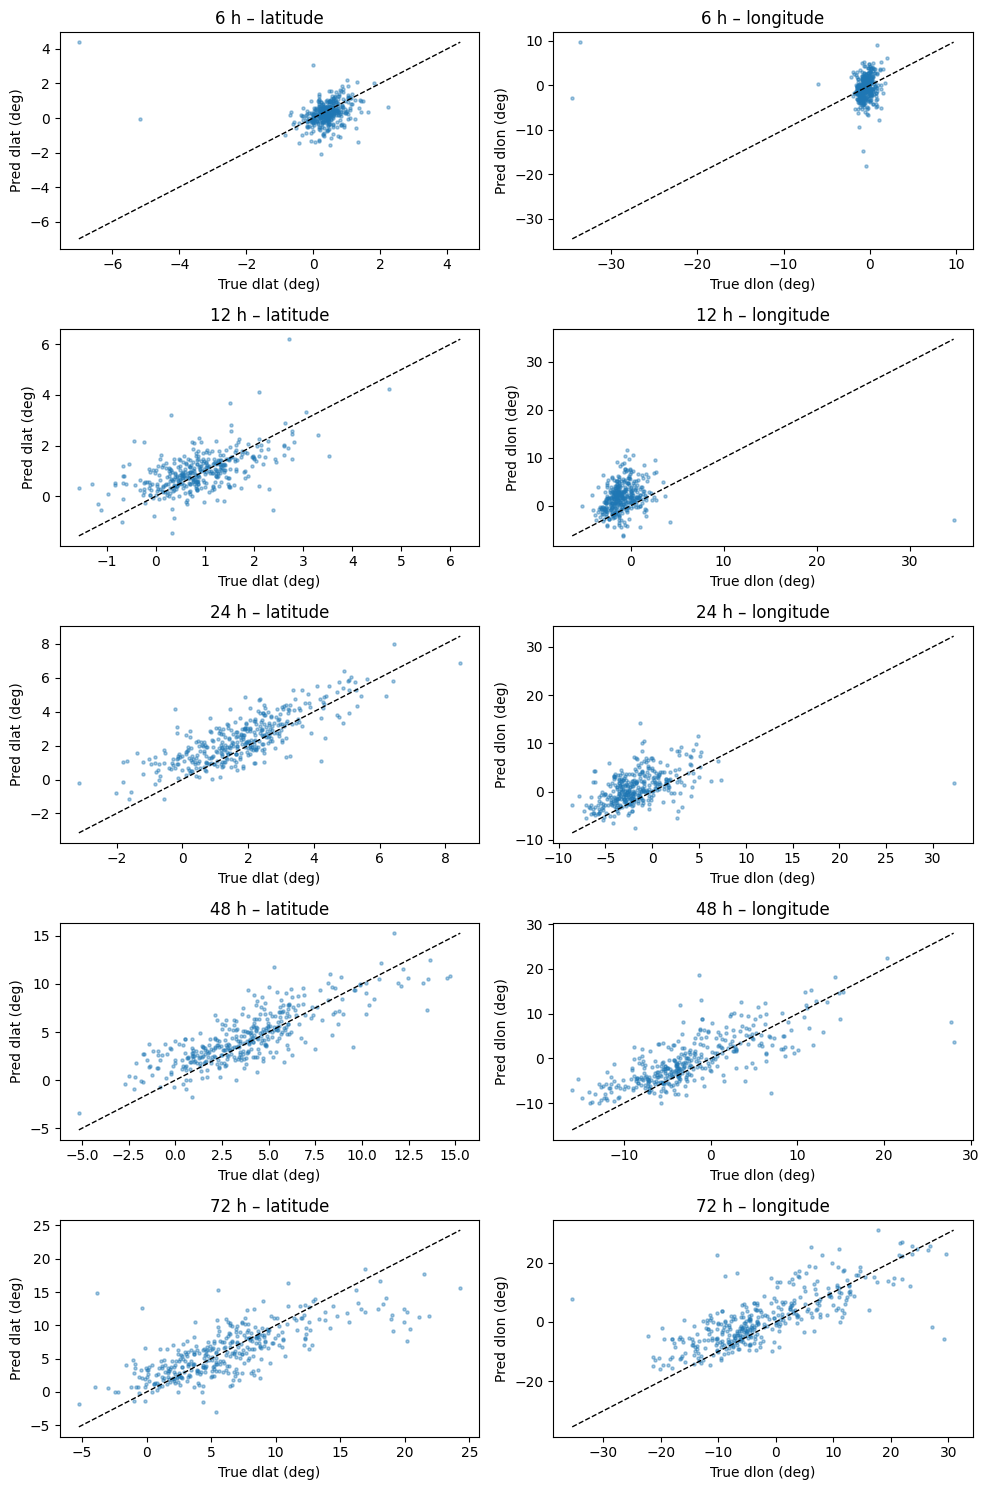

In [28]:
import matplotlib.pyplot as plt

n_leads = len(FORECAST_HOURS)
fig, axes = plt.subplots(n_leads, 2, figsize=(10, 3 * n_leads))

for j, h in enumerate(FORECAST_HOURS):
    ax_lat = axes[j, 0]
    ax_lat.scatter(lat_true[:, j], lat_pred[:, j], s=5, alpha=0.4)
    min_lat = min(lat_true[:, j].min(), lat_pred[:, j].min())
    max_lat = max(lat_true[:, j].max(), lat_pred[:, j].max())
    ax_lat.plot([min_lat, max_lat], [min_lat, max_lat], 'k--', lw=1)
    ax_lat.set_xlabel("True dlat (deg)")
    ax_lat.set_ylabel("Pred dlat (deg)")
    ax_lat.set_title(f"{h} h – latitude")

    ax_lon = axes[j, 1]
    ax_lon.scatter(lon_true[:, j], lon_pred[:, j], s=5, alpha=0.4)
    min_lon = min(lon_true[:, j].min(), lon_pred[:, j].min())
    max_lon = max(lon_true[:, j].max(), lon_pred[:, j].max())
    ax_lon.plot([min_lon, max_lon], [min_lon, max_lon], 'k--', lw=1)
    ax_lon.set_xlabel("True dlon (deg)")
    ax_lon.set_ylabel("Pred dlon (deg)")
    ax_lon.set_title(f"{h} h – longitude")

plt.tight_layout()
plt.show()

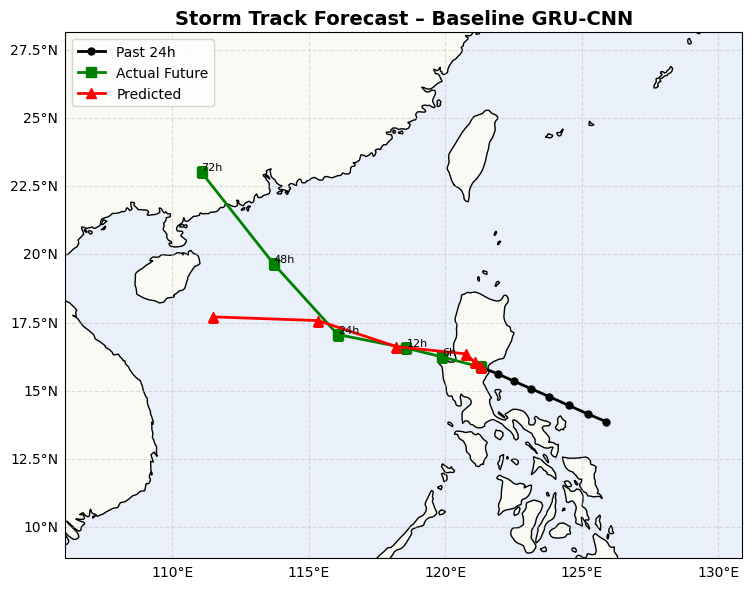

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_baseline_storm(sample_idx=0):
    """
    Plot one test sample: past 24h track, actual future, predicted future.
    """
    global_idx = test_idx[sample_idx]

    past = X_traj[global_idx]

    past_lat = past[:, 0]
    past_lon = past[:, 1]

    lat0 = lat0_test[sample_idx]
    lon0 = lon0_test[sample_idx]

    true_offsets = y_true[sample_idx].reshape(-1, 2)
    pred_offsets = yhat[sample_idx].reshape(-1, 2)

    lat_future_true = lat0 + true_offsets[:, 0]
    lon_future_true = lon0 + true_offsets[:, 1]
    lat_future_pred = lat0 + pred_offsets[:, 0]
    lon_future_pred = lon0 + pred_offsets[:, 1]
    all_lats = np.concatenate([past_lat, lat_future_true, lat_future_pred])
    all_lons = np.concatenate([past_lon, lon_future_true, lon_future_pred])

    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_title("Storm Track Forecast – Baseline GRU-CNN", fontsize=14, fontweight="bold")

    ax.coastlines()
    ax.add_feature(cfeature.LAND, alpha=0.3)
    ax.add_feature(cfeature.OCEAN, alpha=0.2)

    gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.4)
    gl.top_labels = False
    gl.right_labels = False

    ax.plot(
        past_lon, past_lat,
        "-o", color="black", linewidth=2, markersize=5,
        label="Past 24h", transform=ccrs.PlateCarree()
    )

    full_true_lat = np.concatenate([[past_lat[-1]], lat_future_true])
    full_true_lon = np.concatenate([[past_lon[-1]], lon_future_true])

    ax.plot(
        full_true_lon, full_true_lat,
        "-s", color="green", linewidth=2, markersize=7,
        label="Actual Future", transform=ccrs.PlateCarree()
    )

    full_pred_lat = np.concatenate([[past_lat[-1]], lat_future_pred])
    full_pred_lon = np.concatenate([[past_lon[-1]], lon_future_pred])

    ax.plot(
        full_pred_lon, full_pred_lat,
        "-^", color="red", linewidth=2, markersize=7,
        label="Predicted", transform=ccrs.PlateCarree()
    )

    for k, h in enumerate(FORECAST_HOURS):
        ax.text(
            lon_future_true[k], lat_future_true[k], f"{h}h",
            fontsize=8, ha="left", va="bottom", transform=ccrs.PlateCarree()
        )

    margin = 5
    ax.set_extent(
        [all_lons.min() - margin, all_lons.max() + margin,
         all_lats.min() - margin, all_lats.max() + margin]
    )

    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

plot_baseline_storm(sample_idx=9)

In [13]:
!pip install cartopy
import cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 119.2 MB/s eta 0:00:00
